In [94]:
import tensorflow
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [60]:
image_directory = '/content/dataset/images//'
mask_directory = '/content/dataset/masks//'

In [61]:
SIZE = (224, 224, 3)
num_images = 240

In [62]:
image_names = glob.glob(image_directory+"*.jpg")
image_names.sort()
images = []

for image_path in image_names:
    img = cv2.imread(image_path) 
    img = cv2.resize(img, (SIZE[0], SIZE[1]), interpolation = cv2.INTER_NEAREST)
    images.append(img)
image_dataset = np.array(images)

In [63]:
mask_names = glob.glob(mask_directory+"*.jpg")
mask_names.sort()
#mask_names_subset = mask_names[0:num_images]
masks = []
for mask in mask_names:
    img = cv2.imread(mask,0) 
    img = cv2.resize(img, (SIZE[0], SIZE[0]), interpolation = cv2.INTER_NEAREST)
    masks.append(img)
mask_dataset = np.array(masks)

In [64]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (86, 224, 224, 3)
Mask data shape is:  (86, 224, 224)
Max pixel value in image is:  255
Labels in the mask are :  [  0  81  91  99 127 132 155 189 211]


In [65]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
train_masks_reshaped = mask_dataset.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
la = np.unique(train_masks_encoded_original_shape)
n_classes = len(la)
print(la)
print("n_classes", n_classes)

[0 1 2 3 4 5 6 7 8]
n_classes 9


In [67]:
train_masks_encoded_original_shape.shape

(86, 224, 224)

In [68]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
train_masks_input.shape

(86, 224, 224, 1)

In [69]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

#mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.20, random_state = 42)

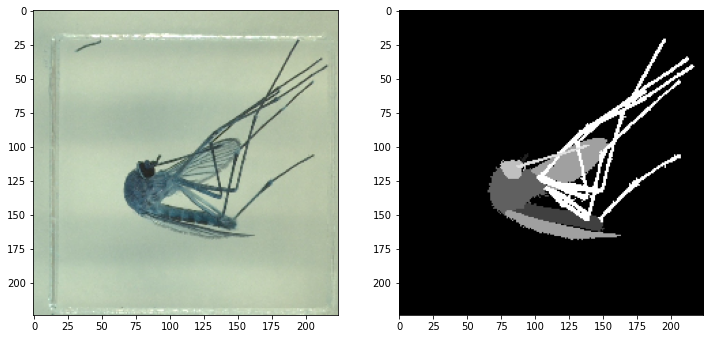

In [71]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [72]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)

X_train.shape (68, 224, 224, 3)
y_train.shape (68, 224, 224, 1)


In [73]:
from keras.utils.np_utils import to_categorical 
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [74]:
print("y_train_cat.shape:", y_train_cat.shape)
print("y_test_cat.shape:", y_test_cat.shape)

y_train_cat.shape: (68, 224, 224, 9)
y_test_cat.shape: (18, 224, 224, 9)


In [77]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate
import tensorflow
def conv3x3(x, out_filters, strides=(1, 1)):
  x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
  return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
  x = conv3x3(input, out_filters, strides)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)

  x = conv3x3(x, out_filters)
  x = BatchNormalization(axis=3)(x)

  if with_conv_shortcut:
    residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
    residual = BatchNormalization(axis=3)(residual)
    x = add([x, residual])
  else:
    x = add([x, input])
    x = Activation('relu')(x)

  return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
  expansion = 4
  de_filters = int(out_filters / expansion)
  x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)
  x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)
  x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization(axis=3)(x)
  if with_conv_shortcut:
      residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
      residual = BatchNormalization(axis=3)(residual)
      x = add([x, residual])
  else:
      x = add([x, input])
  x = Activation('relu')(x)
  return x


def stem_net(input):
  x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
  x = BatchNormalization(axis=3)(x)
  x = Activation('relu')(x)
  # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  # x = BatchNormalization(axis=3)(x)
  # x = Activation('relu')(x)
  x = bottleneck_Block(x, 256, with_conv_shortcut=True)
  x = bottleneck_Block(x, 256, with_conv_shortcut=False)
  x = bottleneck_Block(x, 256, with_conv_shortcut=False)
  x = bottleneck_Block(x, 256, with_conv_shortcut=False)
  return x


def transition_layer1(x, out_filters_list=[32, 64]):
  x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x0 = BatchNormalization(axis=3)(x0)
  x0 = Activation('relu')(x0)
  x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x1 = BatchNormalization(axis=3)(x1)
  x1 = Activation('relu')(x1)
  return [x0, x1]


def make_branch1_0(x, out_filters=32):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x

def make_branch1_1(x, out_filters=64):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x



def fuse_layer1(x):
  x0_0 = x[0]
  x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
  x0_1 = BatchNormalization(axis=3)(x0_1)
  x0_1 = UpSampling2D(size=(2, 2))(x0_1)
  x0 = add([x0_0, x0_1])
  x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
  x1_0 = BatchNormalization(axis=3)(x1_0)
  x1_1 = x[1]
  x1 = add([x1_0, x1_1])
  return [x0, x1]

def transition_layer2(x, out_filters_list=[32, 64, 128]):
  x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
  x0 = BatchNormalization(axis=3)(x0)
  x0 = Activation('relu')(x0)
  x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
  x1 = BatchNormalization(axis=3)(x1)
  x1 = Activation('relu')(x1)
  x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
  x2 = BatchNormalization(axis=3)(x2)
  x2 = Activation('relu')(x2)
  return [x0, x1, x2]

def make_branch2_0(x, out_filters=32):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x

def make_branch2_1(x, out_filters=64):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x

def make_branch2_2(x, out_filters=128):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x


def fuse_layer2(x):
  x0_0 = x[0]
  x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
  x0_1 = BatchNormalization(axis=3)(x0_1)
  x0_1 = UpSampling2D(size=(2, 2))(x0_1)
  x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
  x0_2 = BatchNormalization(axis=3)(x0_2)
  x0_2 = UpSampling2D(size=(4, 4))(x0_2)
  x0 = add([x0_0, x0_1, x0_2])
  x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
  x1_0 = BatchNormalization(axis=3)(x1_0)
  x1_1 = x[1]
  x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
  x1_2 = BatchNormalization(axis=3)(x1_2)
  x1_2 = UpSampling2D(size=(2, 2))(x1_2)
  x1 = add([x1_0, x1_1, x1_2])
  x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
  x2_0 = BatchNormalization(axis=3)(x2_0)
  x2_0 = Activation('relu')(x2_0)
  x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
  x2_0 = BatchNormalization(axis=3)(x2_0)
  x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
  x2_1 = BatchNormalization(axis=3)(x2_1)
  x2_2 = x[2]
  x2 = add([x2_0, x2_1, x2_2])
  return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
  x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
  x0 = BatchNormalization(axis=3)(x0)
  x0 = Activation('relu')(x0)
  x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
  x1 = BatchNormalization(axis=3)(x1)
  x1 = Activation('relu')(x1)
  x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
  x2 = BatchNormalization(axis=3)(x2)
  x2 = Activation('relu')(x2)
  x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
  x3 = BatchNormalization(axis=3)(x3)
  x3 = Activation('relu')(x3)
  return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x


def make_branch3_1(x, out_filters=64):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x


def make_branch3_2(x, out_filters=128):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x

def make_branch3_3(x, out_filters=256):
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  x = basic_Block(x, out_filters, with_conv_shortcut=False)
  return x


def fuse_layer3(x):
  x0_0 = x[0]
  x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
  x0_1 = BatchNormalization(axis=3)(x0_1)
  x0_1 = UpSampling2D(size=(2, 2))(x0_1)
  x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
  x0_2 = BatchNormalization(axis=3)(x0_2)
  x0_2 = UpSampling2D(size=(4, 4))(x0_2)
  x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
  x0_3 = BatchNormalization(axis=3)(x0_3)
  x0_3 = UpSampling2D(size=(8, 8))(x0_3)
  x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
  return x0


def final_layer(x, classes=9):
  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(classes, 1 , use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation('softmax', name = 'SEGMENTATION')(x)
  #o = Conv2D(classes, (1, 1), activation='sigmoid') (x)
  return x


def seg_hrnet(batch_size, height, width, channel, classes):
  inputs = Input(batch_shape=(batch_size,) + (height, width, channel))
  x = stem_net(inputs)
  x = transition_layer1(x)
  x0 = make_branch1_0(x[0])
  x1 = make_branch1_1(x[1])
  x = fuse_layer1([x0, x1])
  x = transition_layer2(x)
  x0 = make_branch2_0(x[0])
  x1 = make_branch2_1(x[1])
  x2 = make_branch2_2(x[2])
  x = fuse_layer2([x0, x1, x2])
  x = transition_layer3(x)
  x0 = make_branch3_0(x[0])
  x1 = make_branch3_1(x[1])
  x2 = make_branch3_2(x[2])
  x3 = make_branch3_3(x[3])
  x = fuse_layer3([x0, x1, x2, x3])

  out = final_layer(x, classes=classes)
  model = Model(inputs=inputs, outputs=out)
  return model

In [78]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(224, 224, 3)


In [79]:
img_height = SIZE[0]
img_width = SIZE[1]
num_channels = 9

hrnet = seg_hrnet(None, img_height, img_width, 3, num_channels)
hrnet.compile(optimizer=Adam(learning_rate = 1e-1), loss='categorical_crossentropy', metrics=['accuracy'])
hrnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [80]:
history = hrnet.fit(X_train, y_train_cat, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=1, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

7/7 [==============================] - 14s 583ms/step - loss: 1.6156 - accuracy: 0.7822 - val_loss: 2023145032970616587044257792.0000 - val_accuracy: 0.0160


In [95]:
hrnet.save('HRNet_224x224.h5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Train IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.legend()
plt.show()

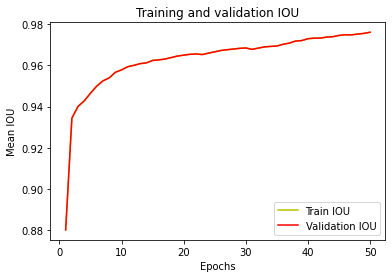

In [83]:
model = hrnet

In [84]:
#Load previously saved model
from keras.models import load_model
model = load_model("Vectech_HRNet_50ep_300img_224x224.h5", compile=False)

In [85]:
#IOU
y_pred = model.predict(X_test)

y_pred_thresholded =np.argmax(y_pred, axis=3)

In [86]:
from keras.metrics import MeanIoU

In [87]:
n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.0017826142


In [89]:
print(y_test.shape)
print(y_pred_thresholded.shape)

(18, 224, 224, 1)
(18, 224, 224)


In [ ]:
i = 11
plt.imshow(y_test[i,:,:,0])
plt.show()
plt.imshow( y_pred_thresholded[i])
plt.show()

In [91]:
def show_results(n):
  for i in range(n):
    threshold = 0.5
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img,0)
    #print(test_img_input.shape)
    prediction = (model.predict(test_img_input))
    prediction_image=np.argmax(prediction, axis=3)[0,:,:]
    #print(prediction.shape
    img = test_im
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,:])
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0],)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction_image)
    plt.show()

In [ ]:
show_results(6)